In [172]:
%pip install xgboost

   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   - -------------------------------------- 4.7/124.9 MB 23.8 MB/s eta 0:00:06
   --- ------------------------------------ 9.7/124.9 MB 23.2 MB/s eta 0:00:05
   ---- ----------------------------------- 14.9/124.9 MB 23.5 MB/s eta 0:00:05
   ------ --------------------------------- 20.2/124.9 MB 24.1 MB/s eta 0:00:05
   ------- -------------------------------- 24.4/124.9 MB 23.4 MB/s eta 0:00:05
   --------- ------------------------------ 29.9/124.9 MB 23.4 MB/s eta 0:00:05
   ---------- ----------------------------- 34.3/124.9 MB 23.2 MB/s eta 0:00:04
   ------------ --------------------------- 39.6/124.9 MB 23.5 MB/s eta 0:00:04
   -------------- ------------------------- 44.8/124.9 MB 23.8 MB/s eta 0:00:04
   --------------- ------------------------ 49.8/124.9 MB 23.7 MB/s eta 0:00:04
   ----------------- ---------------------- 55.3/124.9 MB 24.0 MB/s eta 0:00:03
   ------------------ --------------------- 58.7/12

L2 BOOSTING REGRESSOR

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LassoCV, Ridge
from collections import defaultdict
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [261]:
class L2BoostingRegressor:
    def __init__(self, max_iter=500, shrinkage=0.1, criterion="AIC"):
        # Initialize the L2BoostingRegressor with maximum iterations, shrinkage factor, and stopping criterion
        self.max_iter = max_iter  # Maximum number of boosting iterations
        self.shrinkage = shrinkage  # Shrinkage factor (learning rate)
        self.selected_features = []  # List to store selected features during iterations
        self.beta_final = None  # Final coefficients for the selected features
        self.criterion_history = []  # History of the stopping criterion values (AIC/BIC)
        self.prev_matrix_aic = None  # Stores the previous iteration's hat matrix
        self.criterion = criterion  # Criterion for stopping (either "AIC" or "BIC")

    def fit(self, X, y):
        # Fit the boosting model to the data
        n_samples, n_features = X.shape  # Number of samples and features
        self.selected_features = []  # Reset selected features
        self.beta_final = np.zeros(n_features)  # Initialize coefficients to zero
        residuals = y.copy()  # Initialize residuals as the target variable
        B_m = np.eye(n_samples)  # Initialize hat matrix as the identity matrix
        self.prev_matrix_aic = np.eye(n_samples)  # Initialize the previous hat matrix

        for iteration in range(self.max_iter):
            # Loop through each boosting iteration
            rss = []  # List to store residual sum of squares for each feature

            for j in range(n_features):
                # Evaluate each feature for its contribution
                X_j = X[:, j].reshape(-1, 1)  # Isolate the j-th feature
                coef = np.dot(X_j.T, residuals) / np.dot(X_j.T, X_j)  # Compute coefficient for the feature
                rss.append(mean_squared_error(residuals, (X_j * coef).flatten()))  # Store RSS for the feature

            best_feature = np.argmin(rss)  # Select the feature with the lowest RSS
            self.selected_features.append(best_feature)  # Add selected feature to the list

            X_best = X[:, best_feature].reshape(-1, 1)  # Extract the best feature
            coef = np.dot(X_best.T, residuals) / np.dot(X_best.T, X_best)  # Compute coefficient for the best feature
            contribution = self.shrinkage * coef.item()  # Apply shrinkage factor to the coefficient
            self.beta_final[best_feature] += contribution  # Update the coefficient for the selected feature
            residuals -= contribution * X_best.flatten()  # Update residuals by removing the contribution of the feature

            # Update the hat matrix for the current iteration
            h_j = np.outer(X_best, X_best) / np.dot(X_best.T, X_best)  # Compute influence of the selected feature
            next_matrix = (np.eye(n_samples) - h_j * self.shrinkage) * self.prev_matrix_aic  # Update hat matrix
            B_m = np.eye(n_samples) - next_matrix  # Update the effective hat matrix
            self.prev_matrix_aic = next_matrix  # Store the updated hat matrix

            # Compute variance of residuals
            sigma_hat_squared = np.mean((y - np.dot(B_m, y)) ** 2)

            # Compute the trace of the hat matrix
            trace_B_m = np.trace(B_m)

            # Compute the stopping criterion (AIC or BIC)
            if self.criterion == "AIC":
                value = (
                    np.log(sigma_hat_squared)
                    + (1 + trace_B_m / n_samples) / (1 - (trace_B_m + 2) / n_samples)
                )
            elif self.criterion == "BIC":
                value = np.log(sigma_hat_squared) + (trace_B_m * np.log(n_samples)) / n_samples
            else:
                raise ValueError("Invalid criterion. Use 'AIC' or 'BIC'.")

            self.criterion_history.append(value)  # Store the current criterion value
            print(f"Current {self.criterion}: {value}")

            # Early stopping if the criterion value increases
            if len(self.criterion_history) > 1 and value > self.criterion_history[-2]:
                print(
                    f"Stopping early at iteration {iteration}: {self.criterion} increased from {self.criterion_history[-2]:.4f} to {value:.4f}"
                )
                break

    def predict(self, X):
        # Predict using the fitted model
        return np.dot(X, self.beta_final)


L2 BOOSTING CLASSIFIER

In [347]:
class L2BoostingClassifier:
    def __init__(self, max_iter=500, shrinkage=0.1, criterion="AIC"):
        # Initialize the L2BoostingClassifier with parameters
        self.max_iter = max_iter  
        self.shrinkage = shrinkage  
        self.criterion = criterion  
        self.selected_features = [] 
        self.beta_final = None  
        self.criterion_history = [] 
        self.accuracy_history = [] 
        self.prev_matrix_aic = None

    def fit(self, X, y, X_test, y_test):
        '''
        The test part of the dataset is passed to the function only in order to track the accuracy at every iteration,
        which is done for visualizing and debugging purposes.
        '''
        n_samples, n_features = X.shape  
        self.selected_features = [] 
        self.beta_final = np.zeros(n_features) 
        proba = np.full(n_samples, 0.5) 
        residuals = y - proba  
        B_m = np.eye(n_samples)  
        self.prev_matrix_aic = np.eye(n_samples)  # Store the previous hat matrix (initially it is the identity)

        for iteration in range(self.max_iter):
            
            rss = [] 

            for j in range(n_features):
                # Evaluate each feature's contribution to reducing the residuals
                X_j = X[:, j].reshape(-1, 1)  # Isolate the j-th feature
                coef = np.dot(X_j.T, residuals) / np.dot(X_j.T, X_j)  # Compute coefficient for the feature
                rss.append(log_loss(y, proba + X_j.flatten() * coef.item()))  # Compute log-loss for this feature

            best_feature = np.argmin(rss)  # Select the feature with the lowest log-loss
            self.selected_features.append(best_feature)  # Record the selected feature

            X_best = X[:, best_feature].reshape(-1, 1)  # Extract the best feature
            coef = np.dot(X_best.T, residuals) / np.dot(X_best.T, X_best)  # Compute coefficient for the best feature
            contribution = self.shrinkage * coef.item()  # Apply shrinkage factor to the coefficient
            self.beta_final[best_feature] += contribution  # Update the coefficient for the selected feature
            residuals -= contribution * X_best.flatten()  # Update residuals after accounting for the feature

            # Update probabilities
            proba += self.shrinkage * X_best.flatten() * coef.item()
            proba = np.clip(proba, 0.01, 0.99)  # Ensure probabilities stay within a valid range

            # Calculate accuracy on the test set
            y_pred = self.predict(X_test)  # Predict labels for the test set

            #THIS IS ONLY DONE TO KEEP TRACK OF THE ACCURACY AT EACH ITERATION OF THE ALGORITHM
            accuracy = accuracy_score(y_test, y_pred)  # Calculate accuracy
            self.accuracy_history.append(accuracy)  # Store the accuracy

            # Update the hat matrix for AIC/BIC calculations
            h_j = np.outer(X_best, X_best) / np.dot(X_best.T, X_best)  # Compute influence of the selected feature
            next_matrix = (np.eye(n_samples) - h_j * self.shrinkage) @ self.prev_matrix_aic  # Update hat matrix
            B_m = np.eye(n_samples) - next_matrix  # Update the effective hat matrix
            self.prev_matrix_aic = next_matrix  # Store the updated hat matrix

            # Compute log-likelihood
            log_likelihood = np.sum(
                y * np.log(proba) + (1 - y) * np.log(1 - proba)
            )
            # Compute the trace of the hat matrix
            trace_B_m = np.trace(B_m)

            # Calculate the stopping criterion (AIC or BIC)
            if self.criterion == "AIC":
                value = -2 * log_likelihood + 2 * trace_B_m
            elif self.criterion == "BIC":
                value = -2 * log_likelihood + np.log(n_samples) * trace_B_m
            else:
                raise ValueError("Invalid criterion. Use 'AIC' or 'BIC'.")
            
            self.criterion_history.append(value)  # Store the current criterion value
            
            # Early stopping if the criterion value increases
            if len(self.criterion_history) > 1 and value > self.criterion_history[-2]:
                print(
                    f"Stopping early at iteration {iteration}: {self.criterion} increased from {self.criterion_history[-2]:.4f} to {value:.4f}"
                )
                break

    def predict_proba(self, X):
        # Predict probabilities for each sample
        linear_combination = np.dot(X, self.beta_final)  # Compute linear combination of features
        proba = 1 / (1 + np.exp(-linear_combination))  # Apply the sigmoid function
        return np.clip(proba, 0.01, 0.99)  # Ensure probabilities stay within a valid range

    def predict(self, X):
        # Predict binary labels for each sample
        proba = self.predict_proba(X)  # Compute probabilities
        return (proba >= 0.5).astype(int)  # Classify as 1 if probability >= 0.5, else 0

NUMERICAL EXPERIMENTS

In [254]:
def generate_covariance_matrix(p, block=False):
    if not block:
        return np.eye(p)
    else:

        b, c = 0.677, 0.323
        V = np.zeros((p, p))
        for i in range(p):
            V[i, i] = 1
            if i + 1 < p:
                V[i, i + 1] = b
                V[i + 1, i] = b
            if i + 2 < p:
                V[i, i + 2] = c
                V[i + 2, i] = c
        return V


In [271]:
def generate_data(n, p, covariance_matrix, a_v):
    
    X = np.random.multivariate_normal(mean=np.zeros(p), cov=covariance_matrix, size=n)
    beta = np.zeros(p)
    beta[0], beta[1], beta[2] = 5, 2, 1 
    epsilon = np.random.normal(0, 2, size=n)
    y = a_v * (1 + X @ beta) + epsilon
    return X, y


In [ ]:
n = 20  # Number of samples
p_values = [3, 10, 100]  # Predictor dimensions to test
results = []

for p in p_values:
    for block in [False, True]:  # Test with and without block-correlated predictors
        
        covariance_matrix = generate_covariance_matrix(p, block)  # Generate covariance structure
        a_v = 1 if not block else 0.779  # Scaling factor based on correlation
        
        X, y = generate_data(n, p, covariance_matrix, a_v)  # Generate synthetic dataset
        
        # Train-test split
        X_train, X_test = X[:15], X[15:]
        y_train, y_test = y[:15], y[15:]
        
        # Train L2BoostingRegressor
        l2boost = L2BoostingRegressor(max_iter=5000, shrinkage=0.1, criterion="AIC")
        l2boost.fit(X, y)
        y_pred_boost = l2boost.predict(X)
        boost_mse = mean_squared_error(y, y_pred_boost)
        
        # Train LassoCV
        lasso_cv = LassoCV(cv=10, random_state=42).fit(X_train, y_train)
        y_pred_lasso = lasso_cv.predict(X_test)
        lasso_mse = mean_squared_error(y_test, y_pred_lasso)
        
        # Train Ridge
        ridge = Ridge(alpha=1.0).fit(X_train, y_train)
        y_pred_ridge = ridge.predict(X_test)
        ridge_mse = mean_squared_error(y_test, y_pred_ridge)
        
        # Store results
        results.append({
            "p": p,
            "block": block,
            "L2Boosting MSE": boost_mse,
            "Lasso MSE": lasso_mse,
            "Ridge MSE (alpha=1)": ridge_mse
        })

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print(results_df)

Current AIC: 4.740716431586732
Current AIC: 4.730142296947808
Current AIC: 4.720189517651339
Current AIC: 4.710834407540467
Current AIC: 4.702053378163727
Current AIC: 4.693823028295693
Current AIC: 4.686120225392762
Current AIC: 4.678922178910231
Current AIC: 4.68441465526149
Stopping early at iteration 8: AIC increased from 4.6789 to 4.6844
Current AIC: 4.840987275080318
Current AIC: 4.8308646263816755
Current AIC: 4.820992390232572
Current AIC: 4.814100275922856
Current AIC: 4.804471056537153
Current AIC: 4.797751849843285
Current AIC: 4.788365185827853
Current AIC: 4.781820042532232
Current AIC: 4.772675413489836
Current AIC: 4.766305435544245
Current AIC: 4.757402261012971
Current AIC: 4.751208493893008
Current AIC: 4.742546132390685
Current AIC: 4.736529562529528
Current AIC: 4.728107310709753
Current AIC: 4.722268863022714
Current AIC: 4.7165976957698215
Current AIC: 4.708426490459725
Current AIC: 4.700482097001407
Current AIC: 4.695002410582589
Current AIC: 4.6896872643732435
C

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07083403871054372, tolerance: 0.059245204143674665
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08622182531196643, tolerance: 0.059245204143674665
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0881372720300071, tolerance: 0.059245204143674665
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_

Current AIC: 3.9916221247058576
Current AIC: 3.987566114069244
Current AIC: 3.9879756511623663
Stopping early at iteration 4: AIC increased from 3.9876 to 3.9880
Current AIC: 4.741512566241681
Current AIC: 4.737277601104589
Current AIC: 4.732857289529443
Current AIC: 4.7285365211137815
Current AIC: 4.724561707930018
Current AIC: 4.720699815248035
Current AIC: 4.716625880478191
Current AIC: 4.71265167463381
Current AIC: 4.709049811781713
Current AIC: 4.705560321968526
Current AIC: 4.701833451293349
Current AIC: 4.698206426981842
Current AIC: 4.694976692610696
Current AIC: 4.691858703792406
Current AIC: 4.6884793728059995
Current AIC: 4.685199934116757
Current AIC: 4.683758808366969
Current AIC: 4.6894290190692
Stopping early at iteration 17: AIC increased from 4.6838 to 4.6894
     p  block  L2Boosting MSE  Lasso MSE  Ridge MSE (alpha=1)
0    3  False           2.181      1.471                1.561
1    3   True           1.304      2.089                1.451
2   10  False           3.1

BOOSTING CLASSIFIER CELL DATASET

In [ ]:
df = pd.read_csv("dataset.csv")


X = df.drop(["Condition", "Cell name"], axis=1)
y = df["Condition"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


X_train = X_train.astype(float).values
y_train = y_train.astype(float).values

l2boost_aic = L2BoostingClassifier(max_iter=200, shrinkage=0.1, criterion="AIC")
l2boost_bic = L2BoostingClassifier(max_iter=200, shrinkage=0.1, criterion="BIC")

l2boost_aic.fit(X_train, y_train, X_test, y_test)
l2boost_bic.fit(X_train, y_train, X_test, y_test)


SPARSITY CHECK

In [417]:
total_elements = X.size
total_zeros = np.sum(X == 0)
sparsity_ratio = total_zeros / total_elements

print(f"Total Sparsity Ratio: {sparsity_ratio:.4f}")

Total Sparsity Ratio: 0.4521


SHRINKAGE FACTOR OPTIMIZATION

Running L2Boosting with shrinkage = 0.01
Iteration  0
Best feature is  12102
Iteration 0: Accuracy = 0.4058
Log-likelihood is -109.0587206716529
Trace_B_m is 0.010000000000000564
Current AIC: 218.13744134330582
Iteration  1
Best feature is  12102
Iteration 1: Accuracy = 0.4058
Log-likelihood is -108.609217730294
Trace_B_m is 0.019899999999997364
Current AIC: 217.258235460588
Iteration  2
Best feature is  12102
Iteration 2: Accuracy = 0.4058
Log-likelihood is -108.16847865003147
Trace_B_m is 0.029700999999996425
Current AIC: 216.39635930006295
Iteration  3
Best feature is  12102
Iteration 3: Accuracy = 0.4058
Log-likelihood is -107.73624819188439
Trace_B_m is 0.03940398999999428
Current AIC: 215.55130436376876
Iteration  4
Best feature is  12102
Iteration 4: Accuracy = 0.4058
Log-likelihood is -107.31228220592327
Trace_B_m is 0.049009950099993316
Current AIC: 214.72258431204654
Iteration  5
Best feature is  12102
Iteration 5: Accuracy = 0.4058
Log-likelihood is -106.89634696253486
Trace

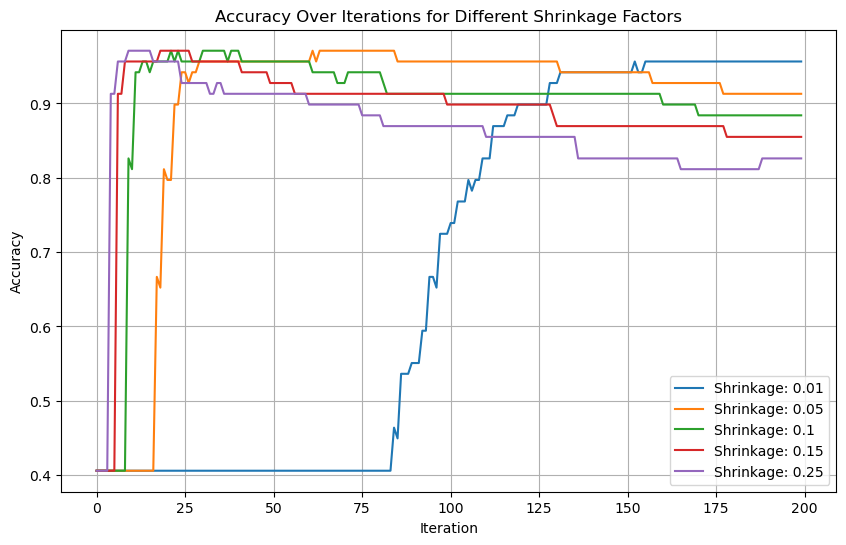

In [ ]:
X = df.drop(["Condition", "Cell name"], axis=1)
y = df["Condition"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Ensure all data is in float format
X_train = X_train.astype(float).values
y_train = y_train.astype(float).values

# Shrinkage factors to evaluate
shrinkage_factors = [0.01, 0.05, 0.1, 0.15, 0.25]
accuracy_results = {}  # To store accuracy for each shrinkage
aic_results = {}  # To store AIC values for each shrinkage

# Loop over each shrinkage factor
for shrinkage in shrinkage_factors:
    print(f"Running L2Boosting with shrinkage = {shrinkage}")
    l2boost = L2BoostingClassifier(max_iter=200, shrinkage=shrinkage)
    l2boost.fit(X_train, y_train, X_test, y_test)
    accuracy_results[shrinkage] = l2boost.accuracy_history
    aic_results[shrinkage] = l2boost.criterion_history

# Plot accuracy over iterations for each shrinkage
plt.figure(figsize=(10, 6))
for shrinkage, accuracies in accuracy_results.items():
    plt.plot(range(len(accuracies)), accuracies, label=f"Shrinkage: {shrinkage}")

plt.xlabel("Iteration") 
plt.ylabel("Accuracy")  
plt.title("Accuracy Over Iterations for Different Shrinkage Factors")  
plt.legend() 
plt.grid() 
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


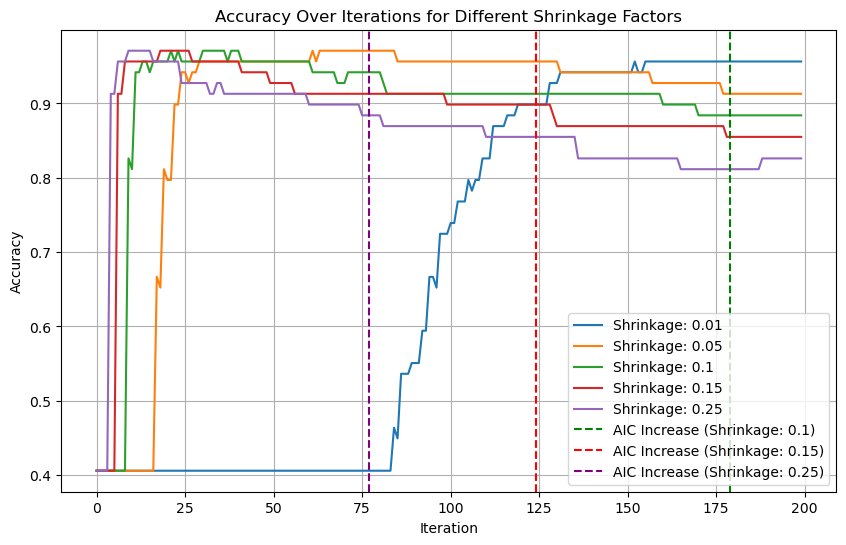

In [ ]:
aic_increase_points = {}
for shrinkage, aic_values in aic_results.items():
    for i in range(1, len(aic_values)):
        if aic_values[i] > aic_values[i - 1]:
            aic_increase_points[shrinkage] = i
            break
line_colors = ['green', 'red', 'purple']

plt.figure(figsize=(10, 6))
for shrinkage, accuracies in accuracy_results.items():
    plt.plot(range(len(accuracies)), accuracies, label=f"Shrinkage: {shrinkage}")
    
for i, (shrinkage, iteration) in enumerate(aic_increase_points.items()):
    color = line_colors[i % len(line_colors)]
    plt.axvline(x=iteration, linestyle='--', color=color, label=f"AIC Increase (Shrinkage: {shrinkage})")

plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Iterations for Different Shrinkage Factors")
plt.legend()
plt.grid()
plt.savefig('accuracy_comparison_shrinkage.eps', format='eps', bbox_inches='tight')
plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


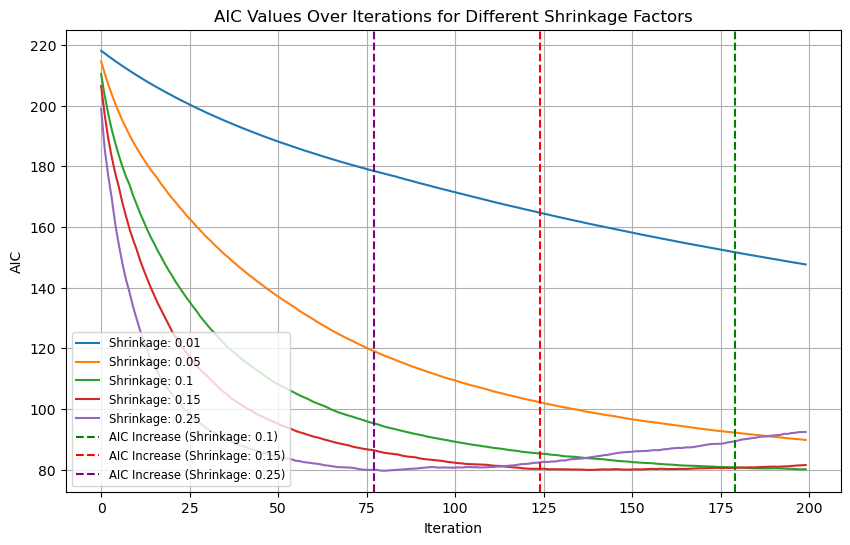

In [374]:
line_colors = ['green', 'red', 'purple']

plt.figure(figsize=(10, 6))
for shrinkage, aic_values in aic_results.items():
    plt.plot(range(len(aic_values)), aic_values, label=f"Shrinkage: {shrinkage}")

for i, (shrinkage, iteration) in enumerate(aic_increase_points.items()):
    color = line_colors[i % len(line_colors)]
    plt.axvline(x=iteration, linestyle='--', color=color, label=f"AIC Increase (Shrinkage: {shrinkage})")

plt.xlabel("Iteration")
plt.ylabel("AIC")
plt.title("AIC Values Over Iterations for Different Shrinkage Factors")
plt.legend(fontsize='small', loc='lower left')
plt.grid()
plt.savefig('aic_comparison_shrinkage.eps', format='eps', bbox_inches='tight')
plt.show()


In [ ]:
shrinkage_trace_map = defaultdict(list)

with open("trace_execution.txt", "r") as file: #This is the trace of the execution
    lines = file.readlines()

current_shrinkage = None
for line in lines:
    line = line.strip()
    if line.startswith("Running L2Boosting with shrinkage"):
        current_shrinkage = float(line.split("=")[-1].strip())
    elif line.startswith("Trace_B_m is"):
        trace_b_m = float(line.split("is")[-1].strip())
        if current_shrinkage is not None:
            shrinkage_trace_map[current_shrinkage].append(trace_b_m)

shrinkage_trace_map = dict(shrinkage_trace_map)


Shrinkage: 0.01, Trace_B_m values: [0.010000000000000564, 0.019899999999997364, 0.029700999999996425, 0.03940398999999428, 0.049009950099993316, 0.05851985059899145, 0.06793465209299931, 0.0772553055720735, 0.08648275251634985, 0.09561792499119126, 0.10466174574128317, 0.11361512828387144, 0.12247897700103438, 0.13125418723102467, 0.13994164535871012, 0.14923358505864803, 0.15779065238263512, 0.1669466266057984, 0.1753754751567842, 0.18439773728196918, 0.19270050220165047, 0.20159126737120991, 0.20977004754091622, 0.21853149331224786, 0.22658835197079452, 0.23522261895668128, 0.24315958430774265, 0.25166877680581723, 0.2594878426149362, 0.2678740292263887, 0.27557715540777183, 0.2838423696454996, 0.291431482838848, 0.30000785239543193, 0.30748712439884596, 0.3155524715744982, 0.3229213700434278, 0.33130122760572556, 0.33920722107144796, 0.34643517449903893, 0.3546560748943185, 0.36240647588578545, 0.36949677030976025, 0.3775624306781724, 0.38516090975207695, 0.39211675217647113, 0.4000

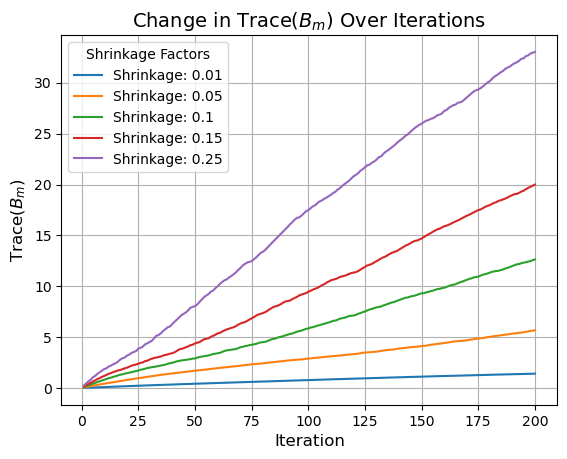

In [ ]:
for shrinkage, trace in shrinkage_trace_map.items():
    plt.plot(range(1, len(trace) + 1), trace, label=f'Shrinkage: {shrinkage}')

plt.title(r'Change in $\text{Trace}(B_m)$ Over Iterations', fontsize=14)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel(r'$\text{Trace}(B_m)$', fontsize=12)
plt.legend(title='Shrinkage Factors')
plt.grid()

plt.show()



ACCURACY VS NUMBER OF SELECTED FEATURES

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


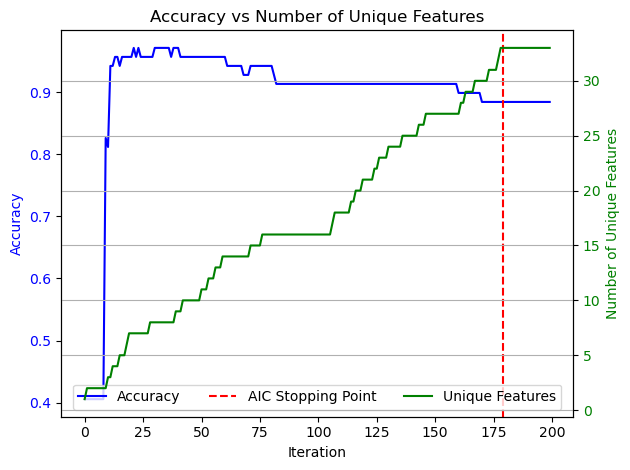

In [406]:
unique_features_count = []
seen_features = set()

for feature in l2boost_aic.selected_features:
    seen_features.add(feature)  
    unique_features_count.append(len(seen_features)) 

fig, ax1 = plt.subplots()

accuracy_line, = ax1.plot(accuracy_results[0.1], label='Accuracy', color='blue')
aic_line = ax1.axvline(x=aic_increase_points[0.1], color="red", linestyle="--", label="AIC Stopping Point")
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Accuracy', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
unique_features_line, = ax2.plot(unique_features_count, label='Unique Features', color='green')
ax2.set_ylabel('Number of Unique Features', color='green')
ax2.tick_params(axis='y', labelcolor='green')


lines = [accuracy_line, aic_line, unique_features_line]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='lower center', bbox_to_anchor=(0.5, 0), ncol=3)

plt.title('Accuracy vs Number of Unique Features')
plt.grid()
plt.tight_layout()
plt.savefig('acc_unique_features.eps', format='eps', bbox_inches='tight')
plt.show()



COMPARISON WITH OTHER ALGORITHMS

In [340]:
df = pd.read_csv("dataset.csv")

X = df.drop(["Condition", "Cell name"], axis=1)
y = df["Condition"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train = X_train.astype(float).values 
X_test = X_test.astype(float).values
y_train = y_train.astype(float).values
y_test = y_test.astype(float).values

log_reg = LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear', random_state=42)  # Solver adjusted for high-dimensional data
log_reg.fit(X_train, y_train)


y_pred = log_reg.predict(X_test)

accuracy_log_reg = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy: {accuracy_log_reg:.4f}")


Logistic Regression Accuracy: 0.9710


c:\Users\leala\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\leala\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


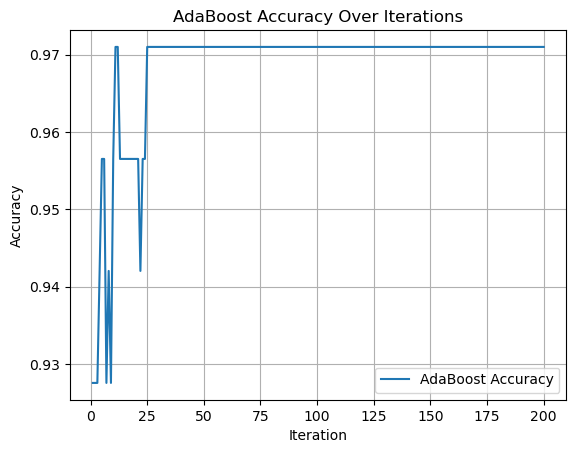

In [407]:
df = pd.read_csv("dataset.csv")


X = df.drop(["Condition", "Cell name"], axis=1) 
y = df["Condition"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
adaboost = AdaBoostClassifier(n_estimators=200, random_state=42)

adaboost.fit(X_train, y_train)

adaboost_acc_history = []

for y_pred in adaboost.staged_predict(X_test):  
    accuracy = accuracy_score(y_test, y_pred)
    adaboost_acc_history.append(accuracy)

plt.plot(range(1, len(adaboost_acc_history) + 1), adaboost_acc_history,label='AdaBoost Accuracy')
plt.title("AdaBoost Accuracy Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()
plt.show()


In [ ]:
X = df.drop(["Condition", "Cell name"], axis=1) 
y = df["Condition"]
xgboost = XGBClassifier(n_estimators=200, use_label_encoder=False, eval_metric='logloss', random_state=42)


xgboost.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

xgboost_acc_history = []

for i in range(1, xgboost.n_estimators + 1):
    y_pred = xgboost.predict(X_test, iteration_range=(0, i))
    accuracy = accuracy_score(y_test, y_pred)
    xgboost_acc_history.append(accuracy)


plt.plot(range(1, len(xgboost_acc_history) + 1), xgboost_acc_history, label='XGBoost Accuracy')
plt.title("XGBoost Accuracy Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()
plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


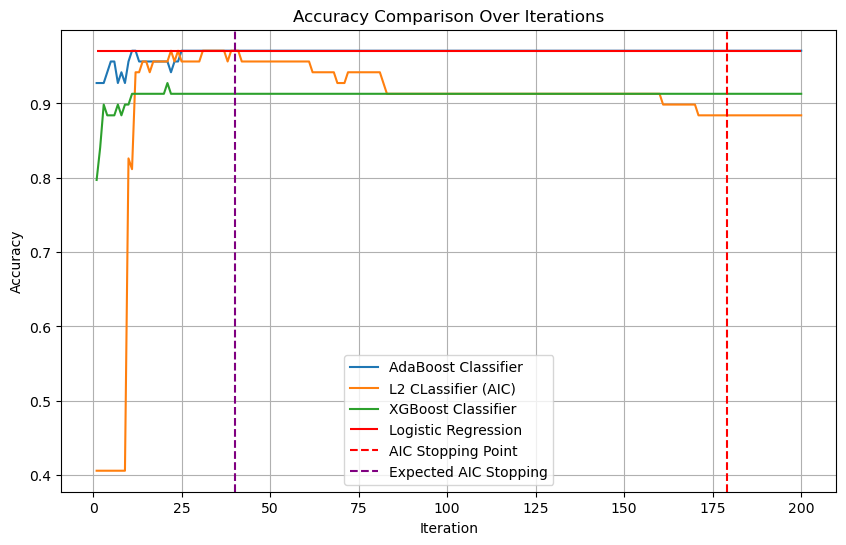

In [412]:
plt.figure(figsize=(10, 6))

max_iter = 200

plt.plot(range(1, min(len(adaboost_acc_history) + 1, max_iter + 1)), 
         adaboost_acc_history[:max_iter], label="AdaBoost Classifier")
plt.plot(range(1, min(len(accuracy_results[0.1]) + 1, max_iter + 1)), 
         accuracy_results[0.1], label="L2 CLassifier (AIC)")
plt.plot(range(1, min(len(xgboost_acc_history) + 1, max_iter + 1)), 
         xgboost_acc_history[:max_iter], label="XGBoost Classifier")
plt.hlines(y=accuracy_log_reg, xmin=1, xmax=max_iter, 
           colors='red', label='Logistic Regression')
plt.axvline(x=aic_increase_points[0.1], color="red", linestyle="--", label="AIC Stopping Point")
plt.axvline(x=40, color="purple", linestyle="--", label="Expected AIC Stopping")

plt.title("Accuracy Comparison Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()
plt.savefig('acc_comparison.eps', format='eps', bbox_inches='tight')
plt.show()


PCA AND AUTOENCODER

In [ ]:
df = pd.read_csv("dataset.csv")
X = df.drop(["Condition", "Cell name"], axis=1)
y = df["Condition"]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify= y
)
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")


Training set shape: (181, 19503)
Testing set shape: (46, 19503)


In [ ]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
pca = PCA(n_components=0.95, svd_solver='full')
pca.fit(X_train_scaled)
n_components = pca.n_components_
print(f"Number of principal components to retain 95% variance: {n_components}")


Number of principal components to retain 95% variance: 125


In [ ]:
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Transformed training set shape: {X_train_pca.shape}")
print(f"Transformed testing set shape: {X_test_pca.shape}")


Transformed training set shape: (181, 125)
Transformed testing set shape: (46, 125)


In [ ]:
l2boost_clf = L2BoostingClassifier(max_iter=1000, shrinkage=0.1) 
l2boost_clf.fit(X_train_pca, y_train, X_test_pca, y_test) 
y_pred = l2boost_clf.predict(X_test_pca)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse:.4f}")
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")


Iteration  0
Best feature is  20
Iteration 0: Accuracy = 0.7391
Log-likelihood is -125.12691634819188
Trace_B_m is 0.09999999999999953
Current AIC: 250.45383269638376
Iteration  1
Best feature is  19
Iteration 1: Accuracy = 0.8478
Log-likelihood is -124.81378343564857
Trace_B_m is 0.19999999999999907
Current AIC: 250.02756687129715
Iteration  2
Best feature is  26
Iteration 2: Accuracy = 0.8478
Log-likelihood is -124.54141510076866
Trace_B_m is 0.3000000000000008
Current AIC: 249.6828302015373
Iteration  3
Best feature is  22
Iteration 3: Accuracy = 0.8261
Log-likelihood is -124.29959817301571
Trace_B_m is 0.39999999999999614
Current AIC: 249.3991963460314
Iteration  4
Best feature is  16
Iteration 4: Accuracy = 0.8043
Log-likelihood is -124.08927927409673
Trace_B_m is 0.4999999999999948
Current AIC: 249.17855854819345
Iteration  5
Best feature is  14
Iteration 5: Accuracy = 0.7826
Log-likelihood is -123.80901929867642
Trace_B_m is 0.5999999999999929
Current AIC: 248.81803859735282
Ite

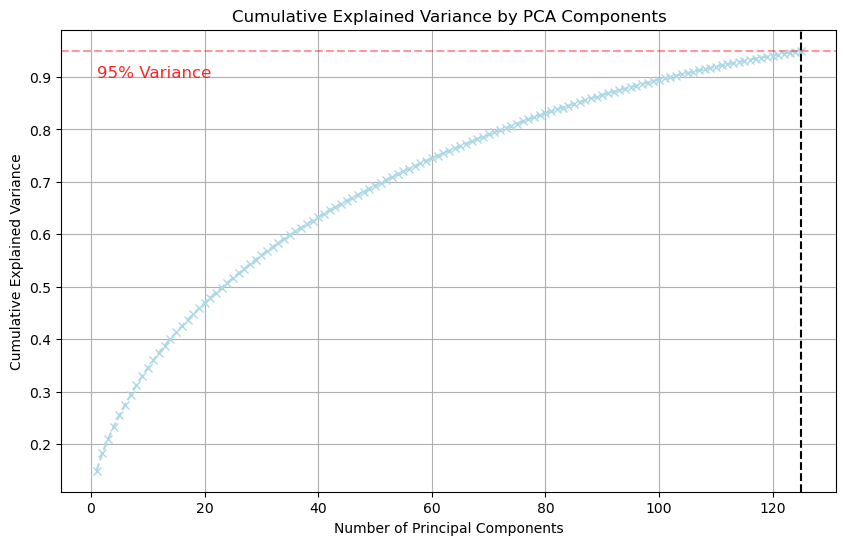

In [ ]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, n_components + 1), cumulative_variance, marker='x', linestyle='--', color='lightblue')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
# Add a horizontal line for the desired variance threshold
desired_variance = 0.95  # 95%
plt.axhline(y=desired_variance, color='red', alpha = 0.4, linestyle='--')
plt.text(1, desired_variance - 0.05, f'{int(desired_variance*100)}% Variance', color='red', alpha = 0.85,fontsize=12)

# Annotate the number of components
plt.axvline(x=n_components, color='black', linestyle='--')
plt.savefig('pcavariance.pdf')
plt.show()


In [ ]:
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (181, 19503)
Testing set shape: (46, 19503)


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
encoding_dim = 100

input_dim = X_train_scaled.shape[1]
input_layer = Input(shape=(input_dim,))

encoded = Dense(256, activation='relu')(input_layer)
encoded = Dropout(0.2)(encoded)
encoded = Dense(128, activation='relu')(encoded)
encoded = Dropout(0.2)(encoded)
encoded = Dense(encoding_dim, activation='relu')(encoded)

decoded = Dense(128, activation='relu')(encoded)
decoded = Dropout(0.2)(decoded)
decoded = Dense(256, activation='relu')(decoded)
decoded = Dropout(0.2)(decoded)
decoded = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)

encoder = Model(inputs=input_layer, outputs=encoded)

autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 19503)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 256)            │     4,993,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 100)            │        12,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 128)            │        12,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 19503)          │     5,012,271 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,097,043 (38.52 MB)

 Trainable params: 10,097,043 (38.52 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = autoencoder.fit(
    X_train_scaled, X_train_scaled,
    epochs=40,
    batch_size=16,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)


Epoch 1/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 1.0093 - val_loss: 1.1540
Epoch 2/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.8680 - val_loss: 1.0724
Epoch 3/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.8772 - val_loss: 1.0769
Epoch 4/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.8444 - val_loss: 1.0760
Epoch 5/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.8549 - val_loss: 1.0915
Epoch 6/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.7807 - val_loss: 1.0819
Epoch 7/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.9111 - val_loss: 1.0739
Epoch 8/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.8753 - val_loss: 1.0814
Epoch 9/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.7791 - val_loss: 1.0795
Epoch 10/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.7418 - val_loss: 1.0780
Epoch 11/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.7970 - val_loss: 1.0832
Epoch 12/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.7405 - val_loss: 1.0887


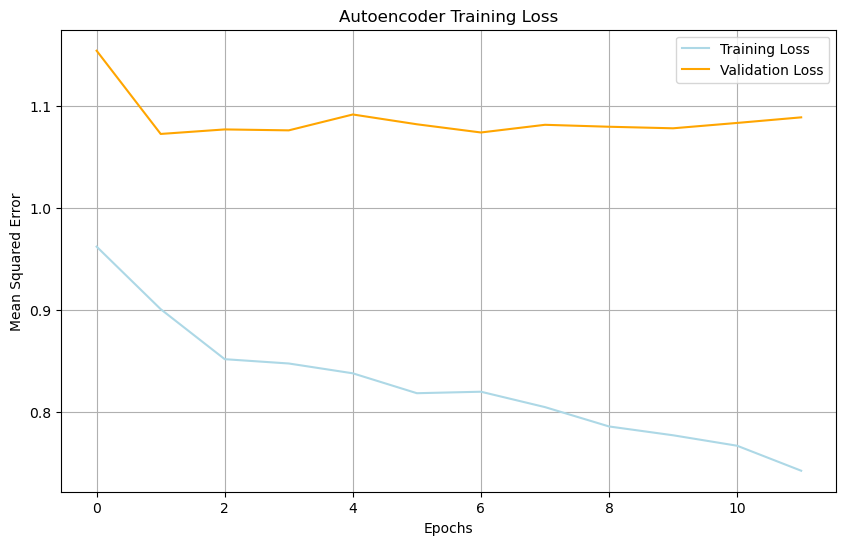

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='lightblue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Autoencoder Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
X_train_encoded = encoder.predict(X_train_scaled)
X_test_encoded = encoder.predict(X_test_scaled)

print(f"Encoded training set shape: {X_train_encoded.shape}")
print(f"Encoded testing set shape: {X_test_encoded.shape}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Encoded training set shape: (181, 100)
Encoded testing set shape: (46, 100)


In [ ]:
l2boost_clf2 = L2BoostingClassifier(max_iter=100, shrinkage=0.1)  # Adjust parameters if needed
l2boost_clf2.fit(X_train_encoded, y_train, X_test_encoded, y_test)

Iteration  0
Best feature is  78
Iteration 0: Accuracy = 0.5217
Log-likelihood is -124.23568719093575
Trace_B_m is 0.09999999339561327
Current AIC: 248.67137436866273
Iteration  1
Best feature is  78
Iteration 1: Accuracy = 0.5217
Log-likelihood is -123.22161977781309
Trace_B_m is 0.18999998800811568
Current AIC: 246.8232395316424
Iteration  2
Best feature is  38
Iteration 2: Accuracy = 0.5000
Log-likelihood is -122.26609061799103
Trace_B_m is 0.2899991330480858
Current AIC: 245.11217950207822
Iteration  3
Best feature is  78
Iteration 3: Accuracy = 0.5000
Log-likelihood is -121.41089231151304
Trace_B_m is 0.37099877002431403
Current AIC: 243.5637821630747
Iteration  4
Best feature is  27
Iteration 4: Accuracy = 0.6087
Log-likelihood is -120.45530554283181
Trace_B_m is 0.4708900659026847
Current AIC: 241.85239121746898
Iteration  5
Best feature is  3
Iteration 5: Accuracy = 0.6304
Log-likelihood is -119.67182923176956
Trace_B_m is 0.5672255590549866
Current AIC: 240.4781095816491
Itera

In [ ]:
y_pred = l2boost_clf2.predict(X_test_encoded)
mse = mean_squared_error(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f'Accuracy: {accuracy}')


Mean Squared Error (MSE): 0.3043
Accuracy: 0.6956521739130435
